In [1]:
import math
import numpy as np
import torch
import gpytorch as gp
from torch.quasirandom import SobolEngine
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm, ttest_ind, ttest_rel

In [2]:
def camel(x1, x2):
    ans = (4 - 2.1*x1**2 + x1**4/3)*x1**2
    ans += x1*x2
    ans += (-4 + 4*x2**2)*x2**2
    return ans

# Data Visualization

In [3]:
domain1 = torch.linspace(-3, 3, 1000)
domain2 = torch.linspace(-2, 2, 1000)
x1, x2 = torch.meshgrid(domain1, domain2, indexing="ij")
y = camel(x1, x2)
print(torch.min(y))
print(torch.max(y))

tensor(-1.0316)
tensor(162.9000)


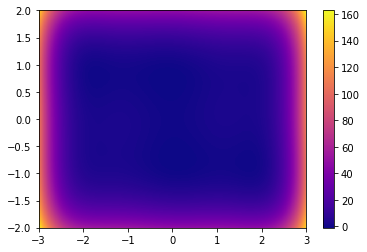

In [4]:
plt.pcolormesh(x1, x2, y, cmap="plasma", shading="auto")
plt.colorbar()
plt.show()

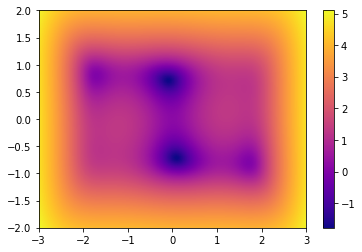

In [5]:
plt.pcolormesh(x1, x2, torch.log(y + 1.2), cmap="plasma", shading="auto")
plt.colorbar()
plt.show()

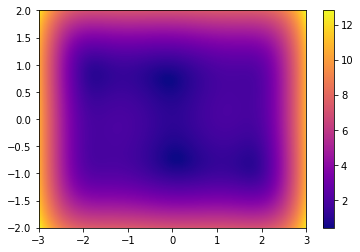

In [6]:
plt.pcolormesh(x1, x2, torch.sqrt(y + 1.2), cmap="plasma", shading="auto")
plt.colorbar()
plt.show()

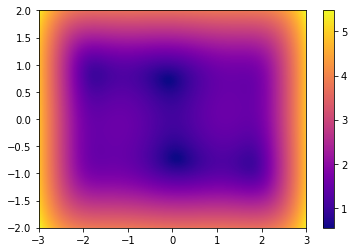

In [7]:
plt.pcolormesh(x1, x2, torch.pow(y + 1.2, 1.0/3), cmap="plasma", shading="auto")
plt.colorbar()
plt.show()

# Model Fitting

In [8]:
class prior(gp.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood, kernel):
        super().__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gp.means.ConstantMean()
        self.covar_module = kernel
    
    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gp.distributions.MultivariateNormal(mean, covar)

def bic(theta, D, mll):
    ans = theta*math.log(D)
    ans -= 2*mll
    return ans

sobol = SobolEngine(2)
seq = sobol.draw_base2(5)

X = torch.vstack(((seq[:, 0]*6-3).clone().detach(), (seq[:, 1]*4-2).clone().detach())).T

k0 = gp.kernels.ScaleKernel(gp.kernels.MaternKernel(nu=2.5))
k1 = gp.kernels.ScaleKernel(gp.kernels.MaternKernel(nu=1.5))
k2 = gp.kernels.ScaleKernel(gp.kernels.RBFKernel())
k3 = gp.kernels.ScaleKernel(gp.kernels.MaternKernel(nu=2.5, ard_num_dims=2))
k4 = gp.kernels.ScaleKernel(gp.kernels.MaternKernel(nu=1.5, ard_num_dims=2))
k5 = gp.kernels.ScaleKernel(gp.kernels.RBFKernel(ard_num_dims=2))
k6 = gp.kernels.SpectralMixtureKernel(num_mixtures=3, ard_num_dims=2)

kernels = [k0, k1, k2, k3, k4, k5, k6]
thetas = [3, 3, 3, 4, 4, 4, 16]

In [9]:
y = camel(X[:, 0], X[:, 1])

likelihood = gp.likelihoods.FixedNoiseGaussianLikelihood(torch.ones(32)*(0.01**2))
k = gp.kernels.ScaleKernel(gp.kernels.MaternKernel(nu=2.5))
model = prior(X, y, likelihood, k)
training_iter = 1000

model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=.1)
mll = gp.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(X)
    loss = -mll(output, y)
    loss.backward()
    optimizer.step()

print("Final Hyperparmeters - Marginal Log Likelihood: {:.4e}   outputscale: {:.4f}   lengthscale: {:.4f}   mean: {:.4f}".format(
    mll(model(X), y),
    model.covar_module.outputscale.item(),
    model.covar_module.base_kernel.lengthscale.item(),
    model.mean_module.constant[0]
  ))
print(torch.exp(mll(model(X), y)))

num = 1000
domain1 = torch.linspace(-3, 3, num)
domain2 = torch.linspace(-2, 2, num)
x1, x2 = torch.meshgrid(domain1, domain2, indexing="ij")
model.eval()
likelihood.eval()
with torch.no_grad(), gp.settings.fast_pred_var():
    test_x = torch.stack([x1.reshape(num*num, 1), x2.reshape(num*num, 1)], -1).squeeze(1)
    f_preds = likelihood(model(test_x), noise=torch.ones(test_x.shape[0])*(0.01**2))
f_means = f_preds.mean.detach().numpy().reshape(num, num)
f_stds = torch.sqrt(f_preds.variance).detach().numpy().reshape(num, num)

plt.pcolormesh(x1, x2, f_means, cmap="plasma", shading="auto")
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c="k", marker="x")
plt.show()

plt.pcolormesh(x1, x2, f_stds, cmap="plasma", shading="auto")
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c="w", marker="x")
plt.show()

residuals = camel(x1, x2) - f_means
residuals = torch.flatten(residuals).view(num*num, 1)
scaler = StandardScaler()
z_scores = scaler.fit_transform(X=residuals)
sns.kdeplot(data=z_scores, legend=False)

for i in range(7):
    likelihood = gp.likelihoods.FixedNoiseGaussianLikelihood(torch.ones(32)*(0.01**2))
    model = prior(X, y, likelihood, kernels[i])
    training_iter = 1000

    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=.01)
    mll = gp.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for j in range(training_iter):
        optimizer.zero_grad()
        output = model(X)
        loss = -mll(output, y)
        loss.backward()
        optimizer.step()
        
    with gp.settings.fast_computations(covar_root_decomposition=False, log_prob=False, solves=False):
        print("BIC {} : {}".format(i, bic(thetas[i], 32, mll(model(X), y))))

In [10]:
y = torch.log(camel(X[:, 0], X[:, 1]) + 1.2)

likelihood = gp.likelihoods.FixedNoiseGaussianLikelihood(torch.ones(32)*(0.01**2))
k = gp.kernels.ScaleKernel(gp.kernels.MaternKernel(nu=2.5))
model = prior(X, y, likelihood, k)
training_iter = 500

model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=.1)
mll = gp.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(X)
    loss = -mll(output, y)
    loss.backward()
    optimizer.step()

print("Final Hyperparmeters - Marginal Log Likelihood: {:.4e}   outputscale: {:.4f}   lengthscale: {:.4f}   mean: {:.4f}".format(
    mll(model(X), y),
    model.covar_module.outputscale.item(),
    model.covar_module.base_kernel.lengthscale.item(),
    model.mean_module.constant[0]
  ))    
print(torch.exp(mll(model(X), y)))

num = 1000
domain1 = torch.linspace(-3, 3, num)
domain2 = torch.linspace(-2, 2, num)
x1, x2 = torch.meshgrid(domain1, domain2, indexing="ij")
model.eval()
likelihood.eval()
with torch.no_grad(), gp.settings.fast_pred_var():
    test_x = torch.stack([x1.reshape(num*num, 1), x2.reshape(num*num, 1)], -1).squeeze(1)
    f_preds = likelihood(model(test_x), noise=torch.ones(test_x.shape[0])*(0.01**2))
f_means = f_preds.mean.detach().numpy().reshape(num, num)
f_stds = torch.sqrt(f_preds.variance).detach().numpy().reshape(num, num)

plt.pcolormesh(x1, x2, f_means, cmap="plasma", shading="auto")
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c="k", marker="x")
plt.show()

plt.pcolormesh(x1, x2, f_stds, cmap="plasma", shading="auto")
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c="w", marker="x")
plt.show()

residuals = torch.log(camel(x1, x2) + 1.2) - f_means
residuals = torch.flatten(residuals).view(num*num, 1)
scaler = StandardScaler()
z_scores = scaler.fit_transform(X=residuals)
sns.kdeplot(data=z_scores, legend=False)

for i in range(7):
    likelihood = gp.likelihoods.FixedNoiseGaussianLikelihood(torch.ones(32)*(0.01**2))
    model = prior(X, y, likelihood, kernels[i])
    training_iter = 500

    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=.01)
    mll = gp.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for j in range(training_iter):
        optimizer.zero_grad()
        output = model(X)
        loss = -mll(output, y)
        loss.backward()
        optimizer.step()
    with gp.settings.fast_computations(covar_root_decomposition=False, log_prob=False, solves=False):
        print("(Transformed) BIC {} : {}".format(i, bic(thetas[i], 32, mll(model(X), y))))

## Duvenaud et al.

In [11]:
class prior(gp.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood, kernel):
        super().__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gp.means.ConstantMean()
        self.covar_module = kernel
    
    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gp.distributions.MultivariateNormal(mean, covar)

def bic(theta, D, mll):
    ans = theta*math.log(D)
    ans -= 2*mll
    return ans

sobol = SobolEngine(2)
seq = sobol.draw_base2(5)

X = torch.vstack(((seq[:, 0]*6-3).clone().detach(), (seq[:, 1]*4-2).clone().detach())).T
y = torch.log(camel(X[:, 0], X[:, 1]) + 1.2)

k0 = gp.kernels.ScaleKernel(gp.kernels.MaternKernel(nu=2.5))
k1 = gp.kernels.ScaleKernel(gp.kernels.MaternKernel(nu=1.5))
k2 = gp.kernels.ScaleKernel(gp.kernels.RBFKernel())
k3 = gp.kernels.ScaleKernel(gp.kernels.MaternKernel(nu=2.5, ard_num_dims=2))
k4 = gp.kernels.ScaleKernel(gp.kernels.MaternKernel(nu=1.5, ard_num_dims=2))
k5 = gp.kernels.ScaleKernel(gp.kernels.RBFKernel(ard_num_dims=2))

base_kernel_names = ["M2.5", "M1.5", "SE", "M2.5_ARD", "M1.5_ARD", "SE_ARD"]
base_kernels = [k0, k1, k2, k3, k4, k5]
kernel_names = ["M2.5", "M1.5", "SE", "M2.5_ARD", "M1.5_ARD", "SE_ARD"]
kernels = [k0, k1, k2, k3, k4, k5]
base_thetas = [3, 3, 3, 4, 4, 4]
thetas = [3, 3, 3, 4, 4, 4]
bics = np.zeros(6)
mlls = np.zeros(6)

best_kernel = None
best_kernel_name = None
best_bic = float("inf")

num_runs = 5
for run in range(num_runs):
    for i in range(len(kernels)):
        likelihood = gp.likelihoods.FixedNoiseGaussianLikelihood(torch.ones(32)*(0.01**2))
        model = prior(X, y, likelihood, kernels[i])
        training_iter = 1000

        model.train()
        likelihood.train()
        optimizer = torch.optim.Adam(model.parameters(), lr=.01)
        mll = gp.mlls.ExactMarginalLogLikelihood(likelihood, model)

        for j in range(training_iter):
            optimizer.zero_grad()
            output = model(X)
            loss = -mll(output, y)
            loss.backward()
            optimizer.step()
        with gp.settings.fast_computations(covar_root_decomposition=False, log_prob=False, solves=False):
            bics[i] = bic(thetas[i], 32, mll(model(X), y))
            mlls[i] = mll(model(X), y)

    best_idx = np.argmin(bics)
    best_k_cur = kernels[best_idx]
    best_bic_cur = bics[best_idx]
    best_mll_cur = mlls[best_idx]
    best_theta_cur = thetas[best_idx]
    best_kernel_name_cur = kernel_names[best_idx]

    if best_bic_cur < best_bic:
        best_kernel = best_k_cur
        best_bic = best_bic_cur
        best_kernel_name = best_kernel_name_cur

    kernels = [None for _ in range(12)]
    thetas = [None for _ in range(12)]
    kernel_names = [None for _ in range(12)]
    bics = np.zeros(12)
    mlls = np.zeros(12)
    for i in range(len(base_kernels)):
        kernels[i] = best_k_cur + base_kernels[i]
        thetas[i] = best_theta_cur + base_thetas[i]
        kernel_names[i] = best_kernel_name_cur + " + " + base_kernel_names[i]
        kernels[i+6] = best_k_cur * base_kernels[i]
        thetas[i+6] = best_theta_cur + base_thetas[i]
        kernel_names[i+6] = best_kernel_name_cur + " * " + base_kernel_names[i]
    
    print("Run {}".format(run+1))
    print(best_kernel_name_cur)
    print(best_bic_cur)
    print(np.exp(best_mll_cur))
    print(kernel_names)
    print(thetas)
    print()

print(best_kernel_name)
print(best_bic)

Final Hyperparmeters - Marginal Log Likelihood: -1.0171e+00   outputscale: 2.2065   lengthscale: 0.9387   mean: 3.4147
tensor(0.3616, grad_fn=<ExpBackward0>)


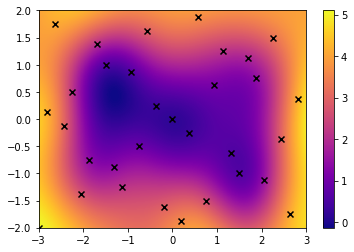

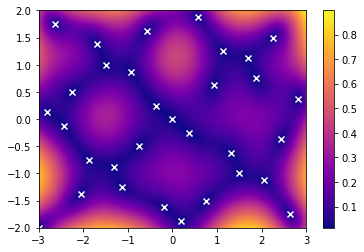

/home/mikejoo/anaconda3/envs/cse544t_fl21/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


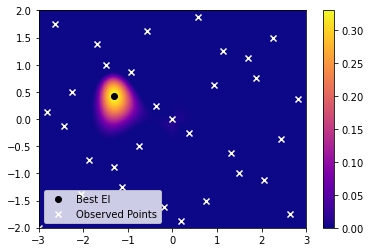

<AxesSubplot:ylabel='Density'>

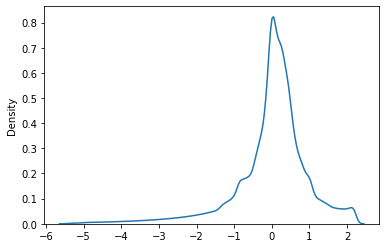

In [14]:
def a_ei(fmin, mean, std):
    ans = (fmin - mean) * norm.cdf((fmin - mean)/std)
    ans += std * norm.pdf((fmin - mean)/std)
    return ans

y = torch.log(camel(X[:, 0], X[:, 1]) + 1.2)
fmin = torch.min(y)

likelihood = gp.likelihoods.FixedNoiseGaussianLikelihood(torch.ones(32)*(0.01**2))
k = gp.kernels.ScaleKernel(gp.kernels.RBFKernel())
model = prior(X, y, likelihood, k)
training_iter = 1000

model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=.1)
mll = gp.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(X)
    loss = -mll(output, y)
    loss.backward()
    optimizer.step()

print("Final Hyperparmeters - Marginal Log Likelihood: {:.4e}   outputscale: {:.4f}   lengthscale: {:.4f}   mean: {:.4f}".format(
    mll(model(X), y),
    model.covar_module.outputscale.item(),
    model.covar_module.base_kernel.lengthscale.item(),
    model.mean_module.constant[0]
  ))    
print(torch.exp(mll(model(X), y)))
  
num = 1000
domain1 = torch.linspace(-3, 3, num)
domain2 = torch.linspace(-2, 2, num)
x1, x2 = torch.meshgrid(domain1, domain2, indexing="ij")
model.eval()
likelihood.eval()
with torch.no_grad(), gp.settings.fast_pred_var():
    test_x = torch.stack([x1.reshape(num*num, 1), x2.reshape(num*num, 1)], -1).squeeze(1)
    f_preds = likelihood(model(test_x), noise=torch.ones(test_x.shape[0])*(0.01**2))
    eis = a_ei(fmin, f_preds.mean, torch.sqrt(f_preds.variance))
f_means = f_preds.mean.detach().numpy().reshape(num, num)
f_stds = torch.sqrt(f_preds.variance).detach().numpy().reshape(num, num)
eis = eis.detach().numpy().reshape(num, num)
max_idx = np.unravel_index(np.argmax(eis), eis.shape)

plt.pcolormesh(x1, x2, f_means, cmap="plasma", shading="auto")
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c="k", marker="x")
plt.show()

plt.pcolormesh(x1, x2, f_stds, cmap="plasma", shading="auto")
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c="w", marker="x")
plt.show()

plt.pcolormesh(x1, x2, eis, cmap="plasma", shading="auto")
plt.colorbar()
plt.scatter(x1[max_idx], x2[max_idx], c="k", marker="o", label='Best EI')
plt.scatter(X[:, 0], X[:, 1], c="w", marker="x", label='Observed Points')
plt.legend()
plt.show()

residuals = torch.log(camel(x1, x2) + 1.2) - f_means
residuals = torch.flatten(residuals).view(num*num, 1)
scaler = StandardScaler()
z_scores = scaler.fit_transform(X=residuals)
sns.kdeplot(data=z_scores, legend=False)